In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

In [36]:
# Load dataset
df = pd.read_csv("fer2013.csv")  # Update with your actual file name

# Map numeric labels to emotion names (if applicable)
emotion_mapping = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# Keep only Angry, Happy, Sad
selected_emotions = ["Angry", "Happy", "Sad","Neutral"]
df["emotion"] = df["emotion"].map(emotion_mapping)  # Convert numbers to names
df = df[df["emotion"].isin(selected_emotions)]

# Save the new dataset
df.to_csv("filtered_fer2013_new.csv", index=False)
print("Filtered dataset saved as filtered_fer2013.csv")


Filtered dataset saved as filtered_fer2013.csv


In [38]:
df.emotion.unique()

array(['Angry', 'Sad', 'Neutral', 'Happy'], dtype=object)

In [39]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [40]:
df.emotion.value_counts()

,count
emotion,
Happy,8989
Neutral,6198
Sad,6077
Angry,4953


In [41]:
df.shape

(26217, 3)

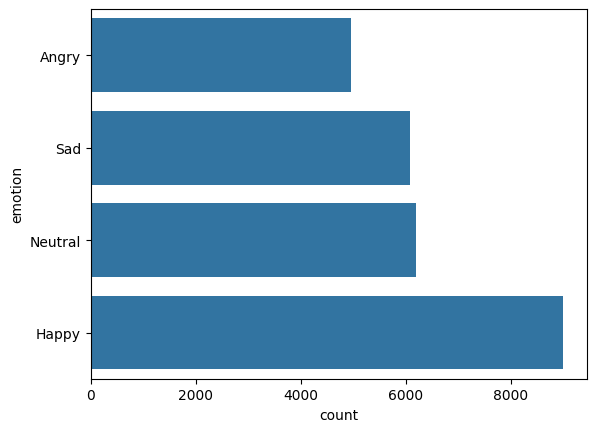

In [42]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [43]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

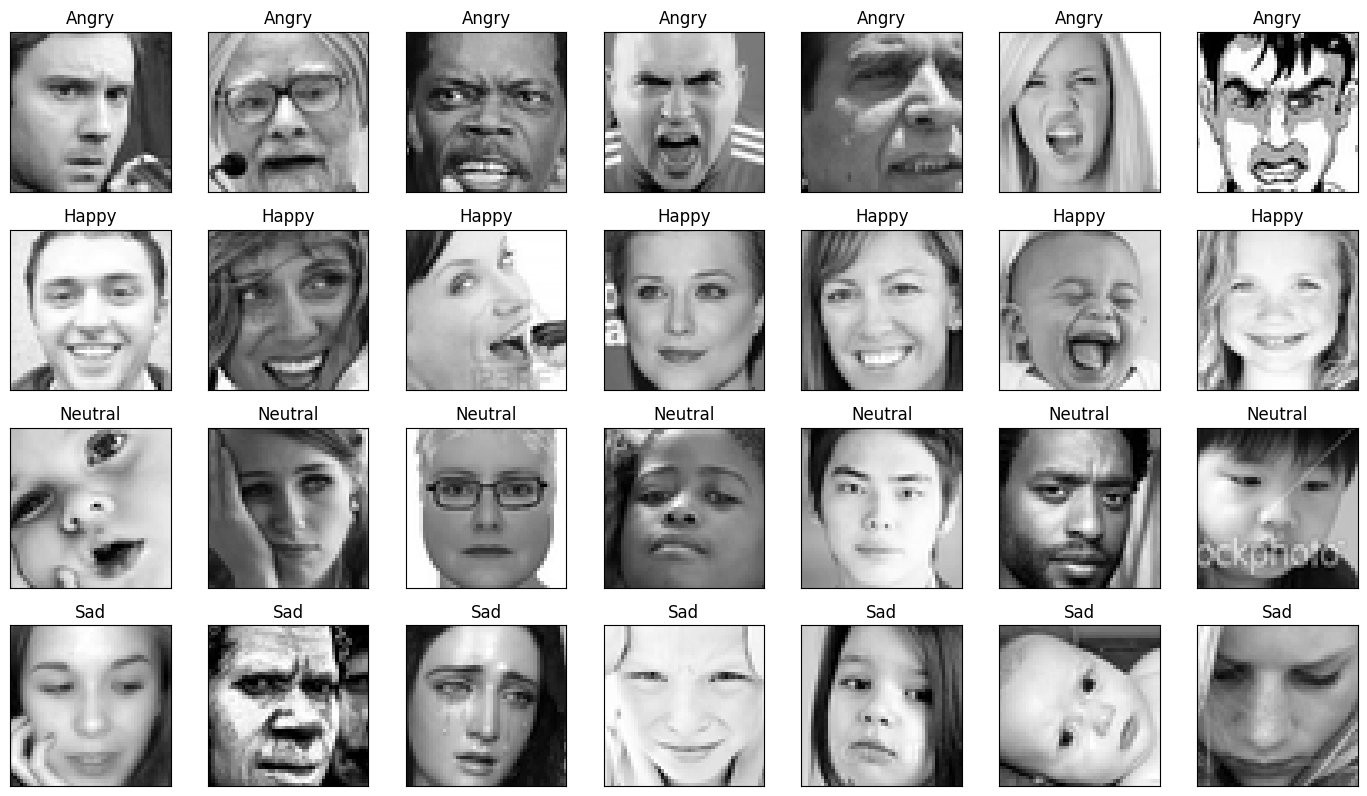

In [44]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        pyplot.tight_layout()

`Now I will make the data compatible for neural networks.`

In [45]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [46]:
img_array.shape

(26217, 48, 48, 1)

In [47]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(26217, 4)

In [48]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Angry': np.int64(0), 'Happy': np.int64(1), 'Neutral': np.int64(2), 'Sad': np.int64(3)}


`Splitting the data into training and validation set.`

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23595, 48, 48, 1), (2622, 48, 48, 1), (23595, 4), (2622, 4))

In [ ]:
del df
del img_array
del img_labels

In [50]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [51]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [52]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [53]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [54]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [57]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,395,204 (9.14 MB)

 Trainable params: 2,393,156 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.2937 - loss: 1.8331 - val_accuracy: 0.4344 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 2/100
  1/737 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.3438 - loss: 1.4116

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


737/737 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.3438 - loss: 1.4116 - val_accuracy: 0.4333 - val_loss: 1.2626 - learning_rate: 0.0010
Epoch 3/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.3813 - loss: 1.3261 - val_accuracy: 0.4516 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 4/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.3438 - loss: 1.3291 - val_accuracy: 0.4439 - val_loss: 1.2464 - learning_rate: 0.0010
Epoch 5/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.4516 - loss: 1.2121 - val_accuracy: 0.5164 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 6/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.5312 - loss: 0.9545 - val_accuracy: 0.5118 - val_loss: 1.1375 - learning_rate: 0.0010
Epoch 7/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5102 - loss: 1.0998 - val_accuracy: 0.5740 - val_loss: 1.0051 - learning_rate: 0.0010
Epoch 8/100
737/737 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.4688 - loss: 

In [59]:
# model_yaml = model.to_yaml()
# with open("model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)

model.save("model.h5")

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

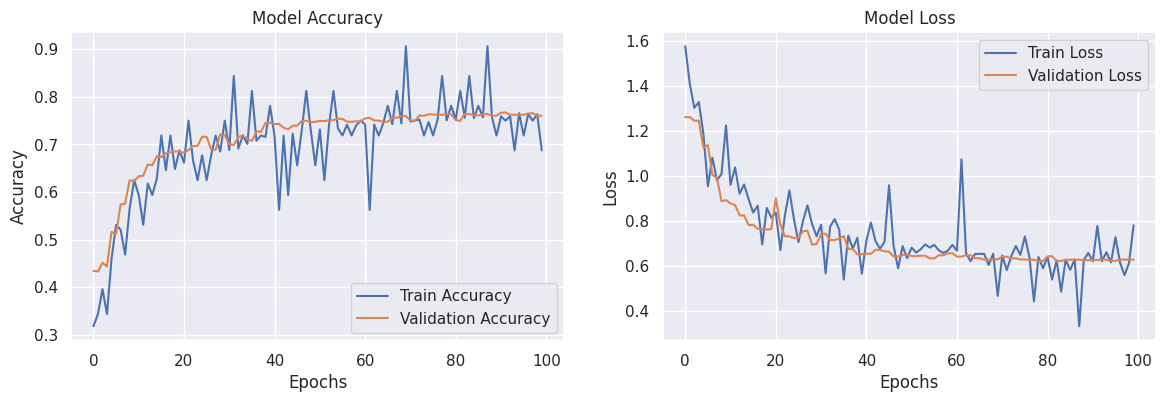

In [68]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig, ax = pyplot.subplots(1, 2, figsize=(14, 4))

# Accuracy Plot
ax[0].plot(df_accu['train'], label="Train Accuracy")
ax[0].plot(df_accu['valid'], label="Validation Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Loss Plot
ax[1].plot(df_loss['train'], label="Train Loss")
ax[1].plot(df_loss['valid'], label="Validation Loss")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

pyplot.savefig('performance_plot.png')
pyplot.show()


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


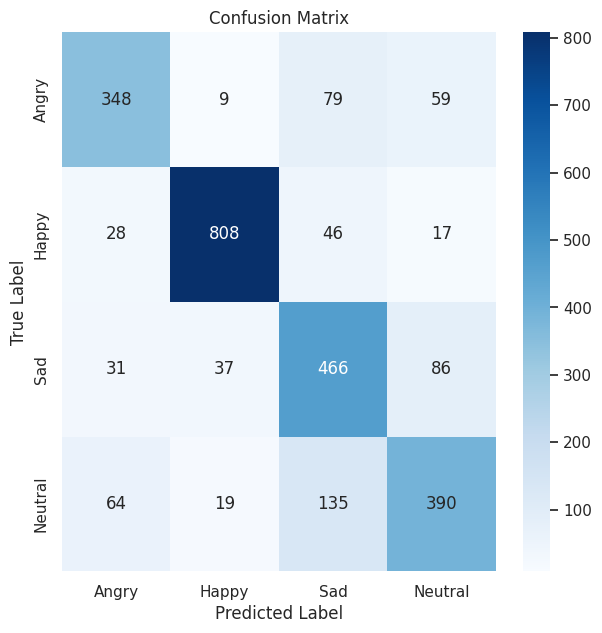

Total wrong validation predictions: 610


              precision    recall  f1-score   support

       Angry       0.74      0.70      0.72       495
       Happy       0.93      0.90      0.91       899
         Sad       0.64      0.75      0.69       620
     Neutral       0.71      0.64      0.67       608

    accuracy                           0.77      2622
   macro avg       0.75      0.75      0.75      2622
weighted avg       0.77      0.77      0.77      2622



In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)  # Convert one-hot encoded labels to class indices

# Compute confusion matrix
cm = confusion_matrix(y_true, yhat_valid)

# Define class labels
class_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

# Plot confusion matrix using Seaborn
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_dcnn.png")
plt.show()

# Print validation errors
print(f'Total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n\n')

# Print classification report
print(classification_report(y_true, yhat_valid, target_names=class_labels))


The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [70]:
mapper = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


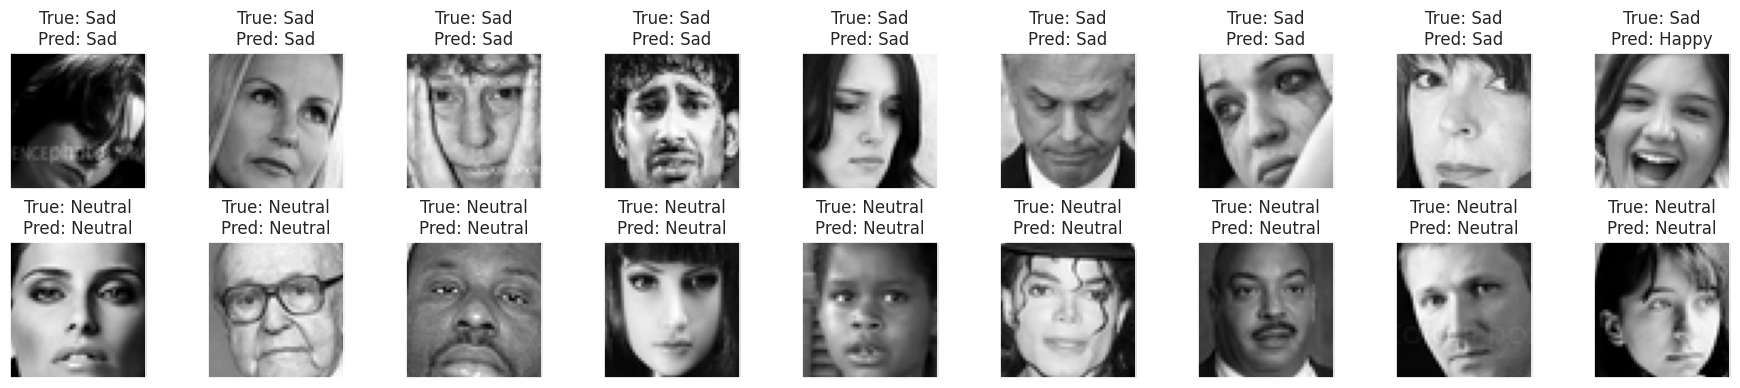

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(2)

# Select random images from 'Sad' and 'Neutral' categories
random_sad_imgs = np.random.choice(np.where(y_valid[:, 3] == 1)[0], size=9, replace=False)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2] == 1)[0], size=9, replace=False)

fig, axes = plt.subplots(2, 9, figsize=(18, 4))  # Create a grid of subplots

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Process Sad Image
    sample_img = X_valid[sadidx, :, :, 0]  # Extract single-channel image
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]

    axes[0, i].imshow(sample_img, cmap='gray')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, i].set_title(f"True: Sad\nPred: {mapper[pred_class]}")

    # Process Neutral Image
    sample_img = X_valid[neuidx, :, :, 0]
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]

    axes[1, i].imshow(sample_img, cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    axes[1, i].set_title(f"True: Neutral\nPred: {mapper[pred_class]}")

plt.tight_layout()  # Apply layout adjustment at the end
plt.show()


See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

In [67]:
model.save("emotion_model.keras")  # Saves in Keras v3 format


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


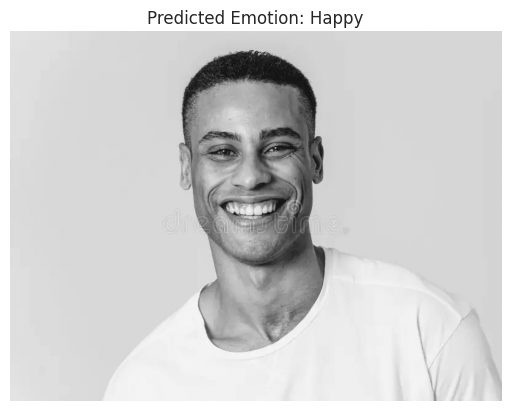

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("emotion_model.keras")  # Use .h5 if needed

# Define class labels
mapper = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (48, 48))  # Resize to (48,48)
    img = img.astype(np.float32) / 255.0  # Normalize (optional)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Predict emotion from image
def predict_emotion(image_path):
    processed_img = preprocess_image(image_path)
    pred_class = np.argmax(model.predict(processed_img), axis=1)[0]
    return mapper[pred_class]

# Test on an image
image_path = "1.jpg"  # Replace with your image path
predicted_emotion = predict_emotion(image_path)

# Display image with predicted label
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


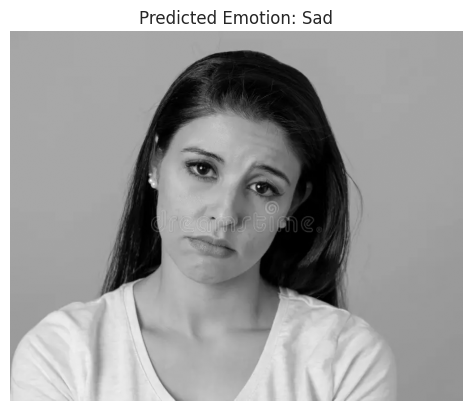

In [86]:
image_path = "3.jpg"  # Replace with your image path
predicted_emotion = predict_emotion(image_path)

# Display image with predicted label
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


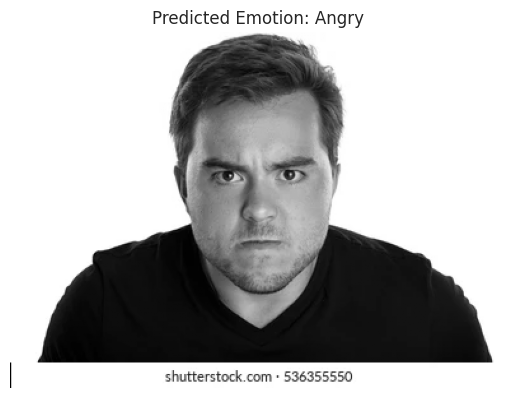

In [88]:
image_path = "5.jpg"  # Replace with your image path
predicted_emotion = predict_emotion(image_path)

# Display image with predicted label
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis("off")
plt.show()